In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [2]:
# Run the stored data from the Data_Preparation.ipynb
%run ..//Data_Preparation.ipynb

Data types in 'indu' dataframe:
Time       datetime64[ns]
indu_Q1           float64
indu_Q2           float64
indu_Q3           float64
indu_Q4           float64
indu_Q5           float64
indu_Q7           float64
dtype: object

Data types in 'cons' dataframe:
Time        datetime64[ns]
cons_Q1            float64
cons_Q2            float64
cons_Q3            float64
cons_Q4            float64
cons_Q5            float64
cons_Q6            float64
cons_Q7            float64
cons_Q8            float64
cons_Q9            float64
cons_Q10           float64
cons_Q11           float64
cons_Q12           float64
dtype: object

Data types in 'gdp' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object
indu_Q1           float64
indu_Q2           float64
indu_Q3           float64
indu_Q4           float64
indu_Q5           float64
indu_Q7           float64
Time       datetime64[ns]
dtype: object
cons_Q1            float64
cons_Q2            float64
cons_Q3            float64
con

In [3]:
#Using the period 1990-2015 for training and 2016-2020 for testing
indu_train = indu[(indu['Time'] >= '1990-01-01') & (indu['Time'] < '2016-01-01')]
cons_train = cons[(cons['Time'] >= '1990-01-01') & (cons['Time'] < '2016-01-01')]
gdp_train = gdp[(gdp['Time'] >= '1990-01-01') & (gdp['Time'] < '2016-01-01')]

indu_test = indu[(indu['Time'] >= '2016-01-01') & (indu['Time'] < '2020-01-01')]
cons_test = cons[(cons['Time'] >= '2016-01-01') & (cons['Time'] < '2020-01-01')]
gdp_test = gdp[(gdp['Time'] >= '2016-01-01') & (gdp['Time'] < '2020-01-01')]

#Since gdp is not stationary, we will take the first difference
gdp_train['Value_diff'] = gdp_train['Value'].diff().fillna(0)
gdp_test['Value_diff'] = gdp_test['Value'].diff().fillna(0)

In [4]:
# Combine the explanatory data into one dataframe
exog_train = pd.merge(indu_train, cons_train, on='Time')
exog_train = exog_train.drop(['Time'], axis=1)

exog_test = pd.merge(indu_test, cons_test, on='Time')
exog_test = exog_test.drop(['Time'], axis=1)

# Extract the essential variables
endog_train = gdp_train['Value_diff'] # Differenced GDP for training
endog_test = gdp_test['Value_diff'] # Differenced GDP for further training contiously in the one step ahead prediction
endog_test_actuals = gdp_test['Value'] # Actual GDP for testing

# Initialize an array to store predictions
y_preds = []

# Define hyperparameters grid for grid search
param_grid = {
    'max_depth': [4, 5, 6],
    'min_child_weight': [5, 10, 15],
    'gamma': [0.5, 1, 1.5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Setting the seed for reproducibility
seed = 42

# Instantiate the XGBoost Regressor model
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', seed=seed)

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Fitting the model
grid_search.fit(exog_train, endog_train)

# Getting the best parameters
best_params = grid_search.best_params_
print("Best parameters found:", best_params)

# Get the best estimator
best_xgb_reg = grid_search.best_estimator_

# Predict one step ahead for each observation in the test set
for i in range(len(exog_test)):
    # Extract current test data point
    current_exog = exog_test.iloc[[i]]
    
    # Train the model on both train and test data up until the current period
    train_exog = pd.concat([exog_train, exog_test.iloc[:i]], axis=0)
    train_endog = pd.concat([endog_train, endog_test.iloc[:i]], axis=0)
    
    # Fit the model on the updated training data
    best_xgb_reg.fit(train_exog, train_endog)
    
    # Predict one step ahead
    y_pred = best_xgb_reg.predict(current_exog)
    y_preds.append(y_pred)

# Convert the list of predictions to a numpy array
y_preds = np.array(y_preds)

# Reverse the first difference and cumulative sum to get actual values
y_preds_norm = np.cumsum(y_preds) + gdp_test['Value'].iloc[0]

# Calculating the RMSE
rmse_value = mean_squared_error(endog_test, y_preds_norm, squared=False)
# Calculating the MAPE
mape_value = mean_absolute_percentage_error(endog_test, y_preds_norm)*100 #Multiplying by 100 to get the percentage

print("The RMSE of the model is:", rmse_value)
print("The MAPE of the model is:", mape_value)

# The RMSE of the model is: 18. The model is accurate in predicting the trend of the GDP, but not the seasonality.
# The MAPE is 1,4%.

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found: {'colsample_bytree': 0.8, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8}
The RMSE of the model is: 544.974538963123
The MAPE of the model is: 1.441050090033644e+19


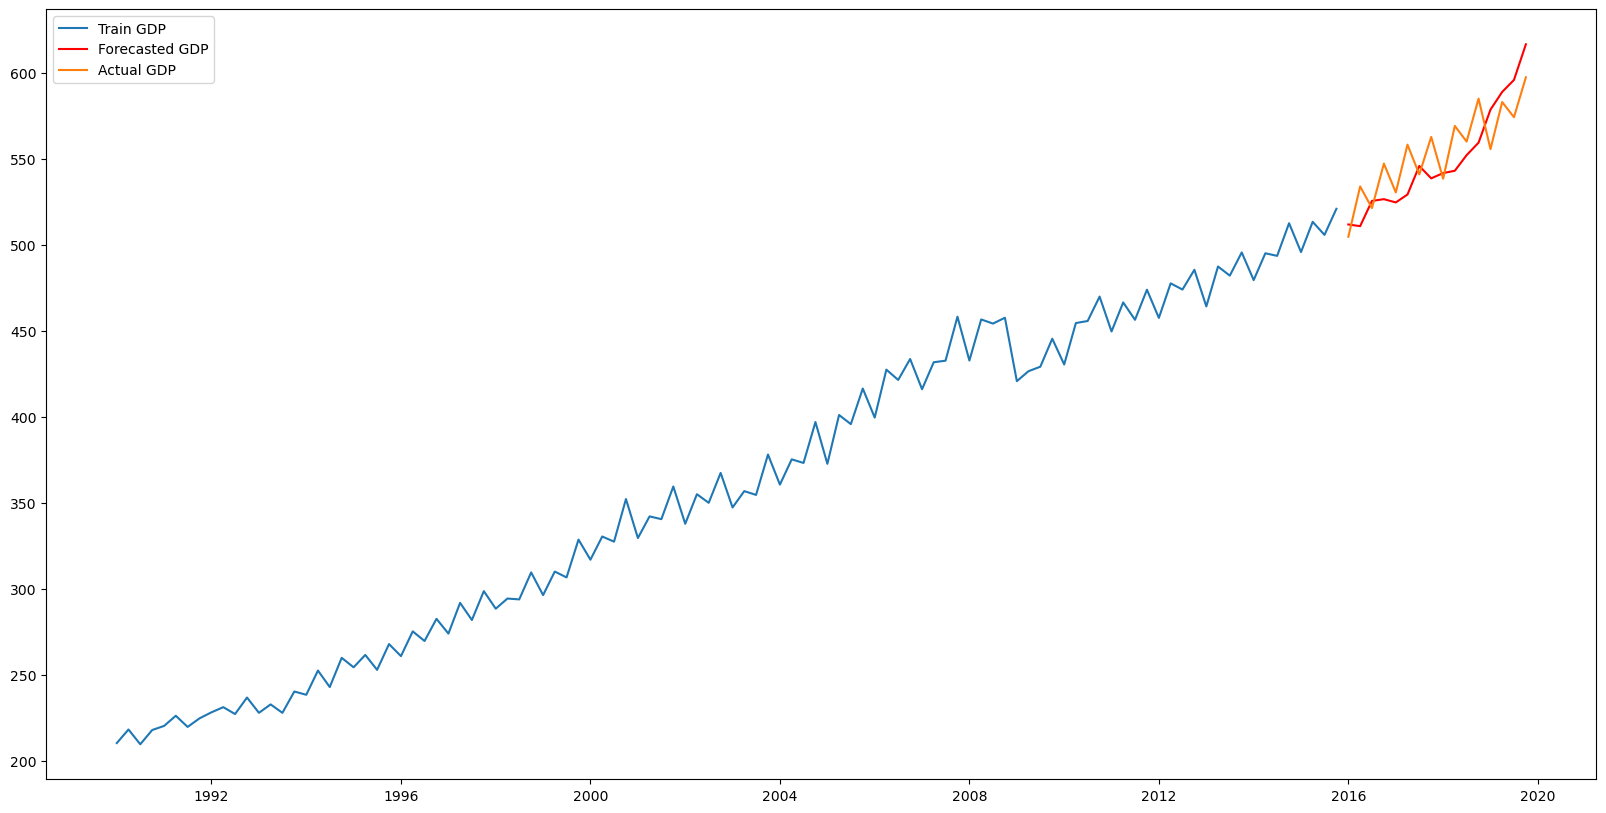

In [5]:
#Plotting the results against the actual values
plt.figure(figsize=(20,10))
plt.plot(gdp_train['Time'], gdp_train['Value'], label='Train GDP')
plt.plot(gdp_test['Time'], y_preds_norm, label='Forecasted GDP', color='red')
plt.plot(gdp_test['Time'], gdp_test['Value'], label='Actual GDP')
plt.legend(loc='upper left')
plt.show()